In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import folium
import models.LinearRegression as lr
import models.RidgeRegression as rr
import models.LassoRegression as ls
import models.RandomForest as RF
import models.NNRegression as nn
import models.GBDT as gbdt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

In [162]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual))

In [163]:
# 初始化一个空字典来保存所有模型的指标
model_metrics = {
    'model_name': [],
    'MAPE': [],
    'MAE': [],
    'R2_Score': []
}

In [164]:
data = pd.read_csv('../data/typhoon_data.csv',index_col=0)
data.head()

International number ID  year  month  day  hour  \
0                     5101  1951      2   19     6   
1                     5101  1951      2   19    12   
2                     5101  1951      2   19    18   
3                     5101  1951      2   20     0   
4                     5101  1951      2   20     6   

                                        grade  Latitude of the center  \
0                         Tropical Depression                     200   
1                         Tropical Depression                     200   
2                         Tropical Depression                     230   
3  Tropical Cyclone of TS intensity or higher                     250   
4  Tropical Cyclone of TS intensity or higher                     276   

   Longitude of the center  Central pressure  Maximum sustained wind speed  \
0                     1385              1010                           NaN   
1                     1385              1010                           NaN   
2                     1421              1000                           NaN   
3                     1460               994                           NaN   
4                     1506               994                           NaN   

  Direction of the longest radius of 50kt winds or greater  \
0                                                NaN         
1                                                NaN         
2                                                NaN         
3                                                NaN         
4                                                NaN         

   The longeast radius of 50kt winds or greater  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

   The shortest radius of 50kt winds or greater  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

  Direction of the longest radius of 30kt winds or greater  \
0                                                NaN         
1                                                NaN         
2                                                NaN         
3                                                NaN         
4                                                NaN         

   The longeast radius of 30kt winds or greater  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

   The shortest radius of 30kt winds or greater  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

  Indicator of landfall or passage  
0                                   
1                                   
2                                   
3                                   
4

In [165]:
# scale values and drops unnecessary columns
data["Latitude of the center"] /= 10
data["Longitude of the center"] /= 10
data = data.drop(["Indicator of landfall or passage"], axis=1)

In [166]:
# Drop rows before year 1977 because they used different method to grade and record typhoons
data = data[data["year"] >= 1977]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43356 entries, 25268 to 68623
Data columns (total 16 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   International number ID                                   43356 non-null  int64  
 1   year                                                      43356 non-null  int64  
 2   month                                                     43356 non-null  int64  
 3   day                                                       43356 non-null  int64  
 4   hour                                                      43356 non-null  int64  
 5   grade                                                     43356 non-null  object 
 6   Latitude of the center                                    43356 non-null  float64
 7   Longitude of the center                                   43356 non-null  float64
 8   Central pressure 

In [167]:
# 移除特定条件下的行
idx = data["grade"] == "Just entering into the responsible area of RSMC Tokyo-Typhoon Center"
data = data.drop(data[idx].index)
# 替换特定字符串数据为缩写
data = data.replace({
    "Tropical Depression": "TD",
    "Severe Tropical Storm": "STS",
    "Tropical Storm": "TS",
    "Extra-tropical Cyclone": "L",
    "Typhoon": "TY"
})

**删除不是台风的行**
* 我们想要预测台风的运动、大小和方向。
* 所以不需要热带低气压和气旋的小信息。

In [168]:
# 处理缺失值
data = data.dropna()
# 删除额外的列
data = data.drop(["Direction of the longest radius of 50kt winds or greater", "Direction of the longest radius of 30kt winds or greater"], axis=1)


## 数据向量化

In [169]:
# 将等级映射到数值
grade_map = {"TD": 1, "TS": 2, "STS": 3, "TY": 4}
data["grade"] = data["grade"].map(grade_map)
# 仅保留每6小时的数据
data = data[data["hour"] % 6 == 0]
# 将每个台风的数据合并到一行
data.head()

International number ID  year  month  day  hour  grade  \
25272                     7701  1977      3   28     0      3   
25273                     7701  1977      3   28     6      3   
25274                     7701  1977      3   28    12      3   
25275                     7701  1977      3   28    18      2   
25276                     7701  1977      3   29     0      2   

       Latitude of the center  Longitude of the center  Central pressure  \
25272                     5.6                    158.8               990   
25273                     6.1                    158.2               996   
25274                     6.6                    157.5              1000   
25275                     7.0                    156.8              1002   
25276                     7.3                    156.0              1002   

       Maximum sustained wind speed  \
25272                          50.0   
25273                          50.0   
25274                          50.0   
25275                          45.0   
25276                          45.0   

       The longeast radius of 50kt winds or greater  \
25272                                           0.0   
25273                                           0.0   
25274                                           0.0   
25275                                           0.0   
25276                                           0.0   

       The shortest radius of 50kt winds or greater  \
25272                                           0.0   
25273                                           0.0   
25274                                           0.0   
25275                                           0.0   
25276                                           0.0   

       The longeast radius of 30kt winds or greater  \
25272                                         125.0   
25273                                         125.0   
25274                                         125.0   
25275                                         100.0   
25276                                         100.0   

       The shortest radius of 30kt winds or greater  
25272                                         125.0  
25273                                         125.0  
25274                                         125.0  
25275                                         100.0  
25276                                         100.0

In [170]:
# 根据国际编号分组，并处理为三维数据集
ids = data["International number ID"].unique()
typhoons = [data[data["International number ID"] == ID].drop(["International number ID"], axis=1) for ID in ids]

In [171]:
ids = data["International number ID"].unique() # Unique IDs of typhoons
typhoons = list()
for ID in ids:
    typhoon = data[data["International number ID"] == ID]
    typhoon = typhoon.drop(["International number ID"], axis=1)
    typhoons.append(typhoon)
print(len(typhoons))

1174


## histogram

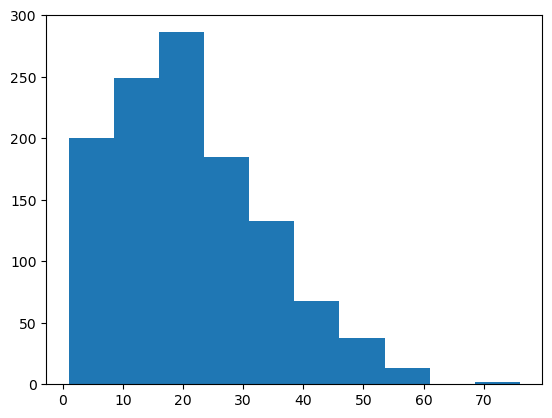

[200. 249. 286. 185. 133.  68.  38.  13.   0.   2.]


In [172]:
hist = data["International number ID"].value_counts()
n = plt.hist(hist)
plt.show()
print(n[0])

## 创建数据集
* 定义一下我们的任务。
* 利用台风之前的状态来预测台风未来的状态。
* 那么我们要使用多少以前的州数据呢?
    * 基本上，每一行之间有6个小时的间隔。但在某些情况下，间隔是3小时。
    * 所以使用3小时前的状态是我们最好的选择。但目前缺乏相关数据。
    * 让我们尝试使用6小时前的数据。
## 总结
* 我们将预测6小时后的台风状态，现在的台风状态和6小时前的台风状态。
* 我们将在下面预测台风的情况。
* 中心位置(经纬度)、中心气压、风速、半径50kt/30kt以上风。

In [173]:
interval = 1
dataset = np.empty((0, 3, 13))
test_typhoons = np.empty((0, 3, 13))

# 预计算台风年份，避免重复计算
for typhoon in typhoons:
    nptyphoon = np.array(typhoon)
    typhoon_year = typhoon.iloc[0]["year"]  # 提前计算台风年份
    num_iterations = nptyphoon.shape[0] - 3  # 提前计算循环次数

    for i in range(0, num_iterations, interval):
        single_data = np.expand_dims(nptyphoon[i:i + 3], axis=0)

        # 将2022年的台风数据作为测试集
        if typhoon_year == 2022:
            test_typhoons = np.append(test_typhoons, single_data, axis=0)
        else:
            dataset = np.append(dataset, single_data, axis=0)

# Machine Learning

In [174]:
scale = StandardScaler()
# 从数据集中提取特征，使用切片操作获取除了最后一列以外的所有列的前两行
x = dataset[:, :2, :]
# 从数据集中提取标签，使用切片操作获取特定列以后的所有部分
y = dataset[:, 2, 5:]
print(x)
print(y)
#由于是GBDT模型，需要将标签转换为一维数组
# 中心气压
y = y[:, 2]
# 最大持续风速
# y = y[:, 3]
print(y)
# 使用train_test_split函数将数据分为训练集和验证集，验证集占30%
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=True)

[[[1977.    3.   28. ...    0.  125.  125.]
  [1977.    3.   28. ...    0.  125.  125.]]

 [[1977.    3.   28. ...    0.  125.  125.]
  [1977.    3.   28. ...    0.  125.  125.]]

 [[1977.    3.   28. ...    0.  125.  125.]
  [1977.    3.   28. ...    0.  100.  100.]]

 ...

 [[2021.   12.   19. ...   90.  240.  150.]
  [2021.   12.   19. ...   90.  240.  150.]]

 [[2021.   12.   19. ...   90.  240.  150.]
  [2021.   12.   19. ...   75.  240.  150.]]

 [[2021.   12.   19. ...   75.  240.  150.]
  [2021.   12.   20. ...   50.  240.  150.]]]
[[   6.6  157.5 1000.  ...    0.   125.   125. ]
 [   7.   156.8 1002.  ...    0.   100.   100. ]
 [   7.3  156.  1002.  ...    0.   100.   100. ]
 ...
 [  16.1  110.7  955.  ...   75.   240.   150. ]
 [  17.2  110.9  970.  ...   50.   240.   150. ]
 [  18.1  111.4  985.  ...   30.   240.   150. ]]
[1000. 1002. 1002. ...  955.  970.  985.]


In [175]:
# 打印训练集和验证集的形状，以便检查数据划分情况
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(14544, 2, 13)
(14544,)
(6234, 2, 13)
(6234,)


In [176]:
# 重塑训练集和验证集的特征，以便于后续的处理或模型训练
x_train = x_train.reshape(-1, 26)
x_val = x_val.reshape(-1, 26)
# 对训练集特征进行标准化处理，fit_transform同时计算和应用标准化参数
x_train = scale.fit_transform(x_train)
# 对验证集特征应用相同的标准化处理，仅使用之前计算的标准化参数进行转换
x_val = scale.transform(x_val)

## ML模型应用分析

LinearRegression on matrix:
Training set MAPE:0.003
Validation set MAPE:0.003
Mean Absolute Error: 2.9495341797831416
R2 Score: 0.964577956233045


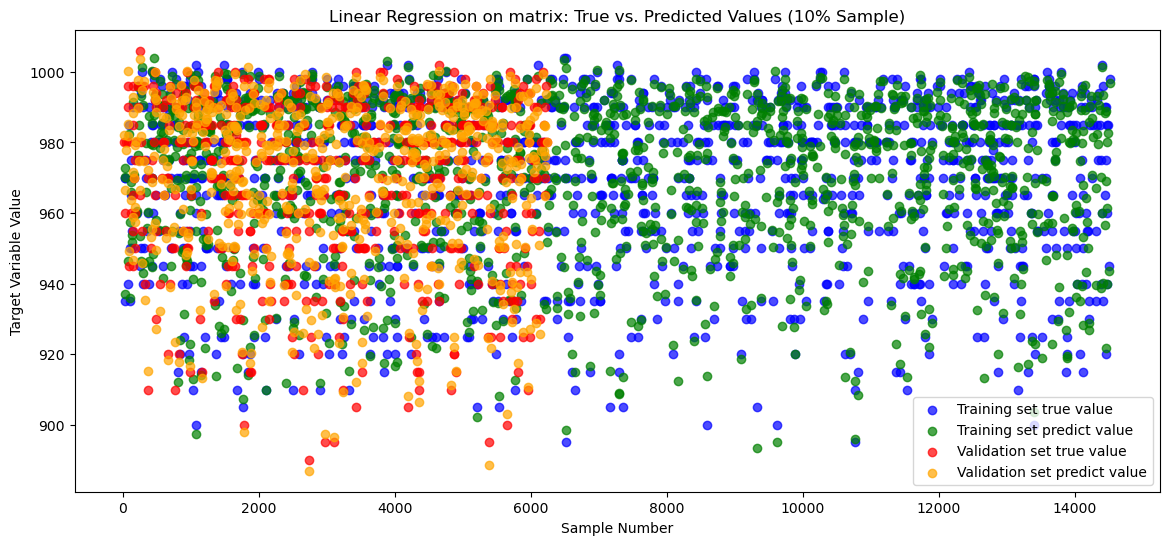

In [177]:
# Initialize the model
lr1_model = lr.LinearRegression()

# 复制数据而不是直接引用
lr1_x_train = x_train.copy()
lr1_y_train = y_train.copy()
lr1_x_val = x_val.copy()
lr1_y_val = y_val.copy()

# Train the model
lr1_model.train(lr1_x_train, lr1_y_train, method="matrix", learning_rate=0.1, n_iters=5000)

print("LinearRegression on matrix:")
# Predict on validation set
y_pred_lr1 = lr1_model.predict(lr1_x_val)
print("Training set MAPE:{:.3f}".format(mape(lr1_model.predict(lr1_x_train), y_train)))
print("Validation set MAPE:{:.3f}".format(mape(y_pred_lr1, y_val)))
print("Mean Absolute Error:", mean_absolute_error(y_val, y_pred_lr1))
print("R2 Score:", r2_score(y_val, y_pred_lr1))

# 保存指标数据
model_metrics['model_name'].append('Linear Regression (Matrix)')
model_metrics['MAPE'].append(mape(y_pred_lr1, y_val))
model_metrics['MAE'].append(mean_absolute_error(y_val, y_pred_lr1))
model_metrics['R2_Score'].append(r2_score(y_val, y_pred_lr1))

# 绘图
plt.figure(figsize=(14, 6))

# 训练集预测值
y_train_pred_lr1 = lr1_model.predict(lr1_x_train)

# 随机选择 10% 的训练集样本用于绘图
train_sample_size = int(len(y_train) * 0.1)
train_indices = np.random.choice(len(y_train), size=train_sample_size, replace=False)

plt.scatter(train_indices, y_train[train_indices], color='blue', label='Training set true value', alpha=0.7)
plt.scatter(train_indices, y_train_pred_lr1[train_indices], color='green', label='Training set predict value', alpha=0.7)

# 验证集预测值
y_val_pred_lr1 = lr1_model.predict(lr1_x_val)

# 随机选择 10% 的验证集样本用于绘图
val_sample_size = int(len(y_val) * 0.1)
val_indices = np.random.choice(len(y_val), size=val_sample_size, replace=False)

plt.scatter(val_indices, y_val[val_indices], color='red', label='Validation set true value', alpha=0.7)
plt.scatter(val_indices, y_pred_lr1[val_indices], color='orange', label='Validation set predict value', alpha=0.7)

plt.title('Linear Regression on matrix: True vs. Predicted Values (10% Sample)')
plt.xlabel('Sample Number')
plt.ylabel('Target Variable Value')
plt.legend()
plt.show()
plt.close()


LinearRegression on gradient:
Training set MAPE:0.003
Validation set MAPE:0.003
Mean Absolute Error: 3.033113868100626
R2 Score: 0.9625238130791062


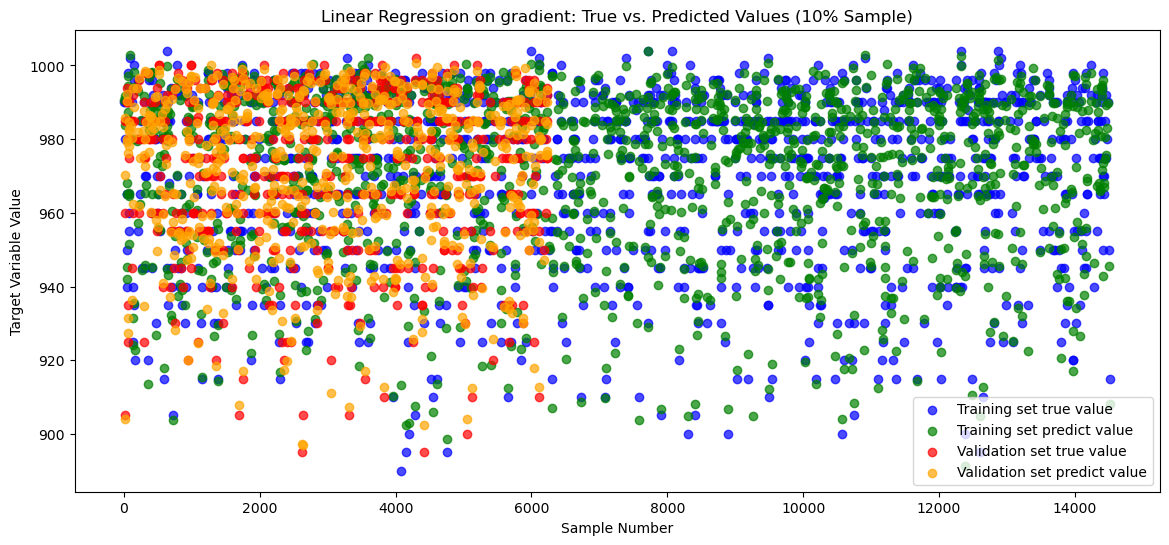

In [178]:
# Initialize the model
lr2_model = lr.LinearRegression()

# 复制数据而不是直接引用
lr2_x_train = x_train.copy()
lr2_y_train = y_train.copy()
lr2_x_val = x_val.copy()
lr2_y_val = y_val.copy()

# Train the model
lr2_model.train(lr2_x_train, lr2_y_train, method="gradient", learning_rate=0.01, n_iters=5000)

print("LinearRegression on gradient:")
# Predict on validation set
y_pred_lr2 = lr2_model.predict(lr2_x_val)
print("Training set MAPE:{:.3f}".format(mape(lr2_model.predict(lr2_x_train), y_train)))
print("Validation set MAPE:{:.3f}".format(mape(y_pred_lr2, y_val)))
print("Mean Absolute Error:", mean_absolute_error(y_val, y_pred_lr2))
print("R2 Score:", r2_score(y_val, y_pred_lr2))

# 保存指标数据
model_metrics['model_name'].append('Linear Regression (Gradient)')
model_metrics['MAPE'].append(mape(y_pred_lr2, y_val))
model_metrics['MAE'].append(mean_absolute_error(y_val, y_pred_lr2))
model_metrics['R2_Score'].append(r2_score(y_val, y_pred_lr2))

# 绘图
plt.figure(figsize=(14, 6))

# 训练集预测值
y_train_pred_lr2 = lr2_model.predict(lr2_x_train)

# 随机选择 10% 的训练集样本用于绘图
train_sample_size = int(len(y_train) * 0.1)
train_indices = np.random.choice(len(y_train), size=train_sample_size, replace=False)

plt.scatter(train_indices, y_train[train_indices], color='blue', label='Training set true value', alpha=0.7)
plt.scatter(train_indices, y_train_pred_lr2[train_indices], color='green', label='Training set predict value', alpha=0.7)

# 验证集预测值
y_val_pred_lr2 = lr2_model.predict(lr2_x_val)

# 随机选择 10% 的验证集样本用于绘图
val_sample_size = int(len(y_val) * 0.1)
val_indices = np.random.choice(len(y_val), size=val_sample_size, replace=False)

plt.scatter(val_indices, y_val[val_indices], color='red', label='Validation set true value', alpha=0.7)
plt.scatter(val_indices, y_pred_lr2[val_indices], color='orange', label='Validation set predict value', alpha=0.7)

plt.title('Linear Regression on gradient: True vs. Predicted Values (10% Sample)')
plt.xlabel('Sample Number')
plt.ylabel('Target Variable Value')
plt.legend()
plt.show()
plt.close()


Ridge Regression:
Training set MAPE:0.003
Validation set MAPE:0.003
Mean Absolute Error: 2.9498232638894266
R2 Score: 0.9645743863007578


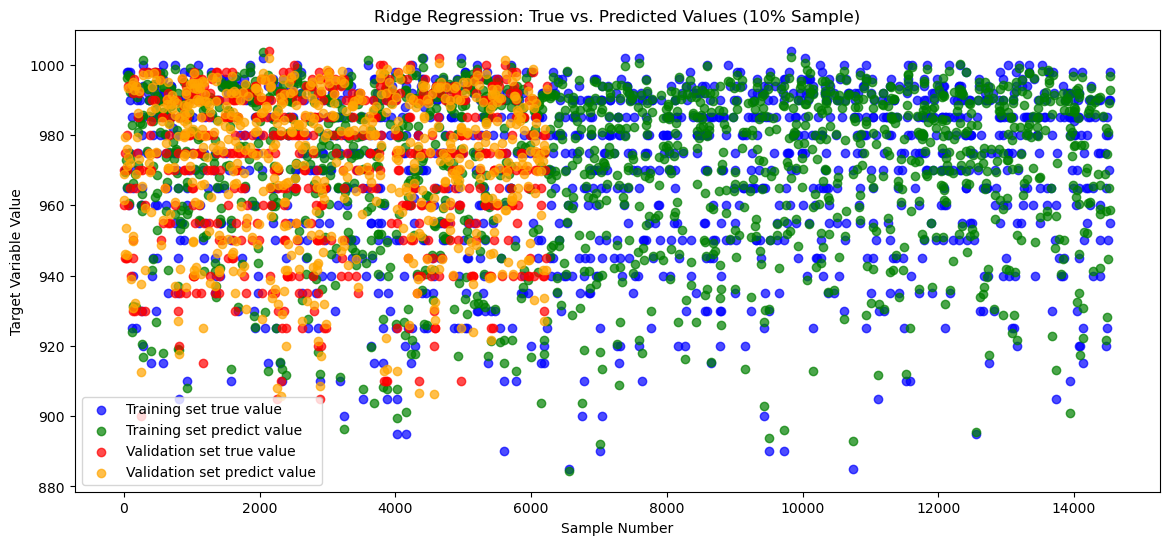

In [179]:
# Initialize the model
rr_model = rr.RidgeRegression()

# 复制数据而不是直接引用
rr_x_train = x_train.copy()
rr_y_train = y_train.copy()
rr_x_val = x_val.copy()
rr_y_val = y_val.copy()

# Train the model
rr_model.train(rr_x_train, rr_y_train, lambdas=0.2)

print("Ridge Regression:")
# Predict on validation set
y_pred_rr = rr_model.predict(rr_x_val)
print("Training set MAPE:{:.3f}".format(mape(rr_model.predict(rr_x_train), y_train)))
print("Validation set MAPE:{:.3f}".format(mape(y_pred_rr, y_val)))
print("Mean Absolute Error:", mean_absolute_error(y_val, y_pred_rr))
print("R2 Score:", r2_score(y_val, y_pred_rr))

# 保存指标数据
model_metrics['model_name'].append('Ridge Regression')
model_metrics['MAPE'].append(mape(y_pred_rr, y_val))
model_metrics['MAE'].append(mean_absolute_error(y_val, y_pred_rr))
model_metrics['R2_Score'].append(r2_score(y_val, y_pred_rr))

# 绘图
plt.figure(figsize=(14, 6))

# 训练集预测值
y_train_pred_rr = rr_model.predict(rr_x_train)

# 随机选择 10% 的训练集样本用于绘图
train_sample_size = int(len(y_train) * 0.1)
train_indices = np.random.choice(len(y_train), size=train_sample_size, replace=False)

plt.scatter(train_indices, y_train[train_indices], color='blue', label='Training set true value', alpha=0.7)
plt.scatter(train_indices, y_train_pred_rr[train_indices], color='green', label='Training set predict value', alpha=0.7)

# 验证集预测值
y_val_pred_rr = rr_model.predict(rr_x_val)

# 随机选择 10% 的验证集样本用于绘图
val_sample_size = int(len(y_val) * 0.1)
val_indices = np.random.choice(len(y_val), size=val_sample_size, replace=False)

plt.scatter(val_indices, y_val[val_indices], color='red', label='Validation set true value', alpha=0.7)
plt.scatter(val_indices, y_pred_rr[val_indices], color='orange', label='Validation set predict value', alpha=0.7)

plt.title('Ridge Regression: True vs. Predicted Values (10% Sample)')
plt.xlabel('Sample Number')
plt.ylabel('Target Variable Value')
plt.legend()
plt.show()
plt.close()


第1次迭代，第w0参数优化后，损失平方和为13687987408.398525，损失前后差为25102.76386833191
第1次迭代，第w1参数优化后，损失平方和为13687611889.518406，损失前后差为375518.88011932373
第1次迭代，第w2参数优化后，损失平方和为13687507642.233334，损失前后差为104247.28507232666
第1次迭代，第w3参数优化后，损失平方和为13687496183.503323，损失前后差为11458.730010986328
第1次迭代，第w4参数优化后，损失平方和为13678986713.907112，损失前后差为8509469.59621048
第1次迭代，第w5参数优化后，损失平方和为13678986710.048828，损失前后差为3.8582839965820312
第1次迭代，第w6参数优化后，损失平方和为13678785531.762842，损失前后差为201178.28598594666
第1次迭代，第w7参数优化后，损失平方和为13677895884.274807，损失前后差为889647.488035202
第1次迭代，第w8参数优化后，损失平方和为13677845973.380281，损失前后差为49910.894525527954
第1次迭代，第w9参数优化后，损失平方和为13677844193.27729，损失前后差为1780.102991104126
第1次迭代，第w10参数优化后，损失平方和为13677843723.938446，损失前后差为469.3388442993164
第1次迭代，第w11参数优化后，损失平方和为13677741712.297235，损失前后差为102011.64121055603
第1次迭代，第w12参数优化后，损失平方和为13677738992.996407，损失前后差为2719.300828933716
第1次迭代，第w13参数优化后，损失平方和为13677718193.854904，损失前后差为20799.14150238037
第1次迭代，第w14参数优化后，损失平方和为13677597555.045753，损失前后差为120638.8091506958
第1次迭代，第w15参数优化后，损失平方和为136775862

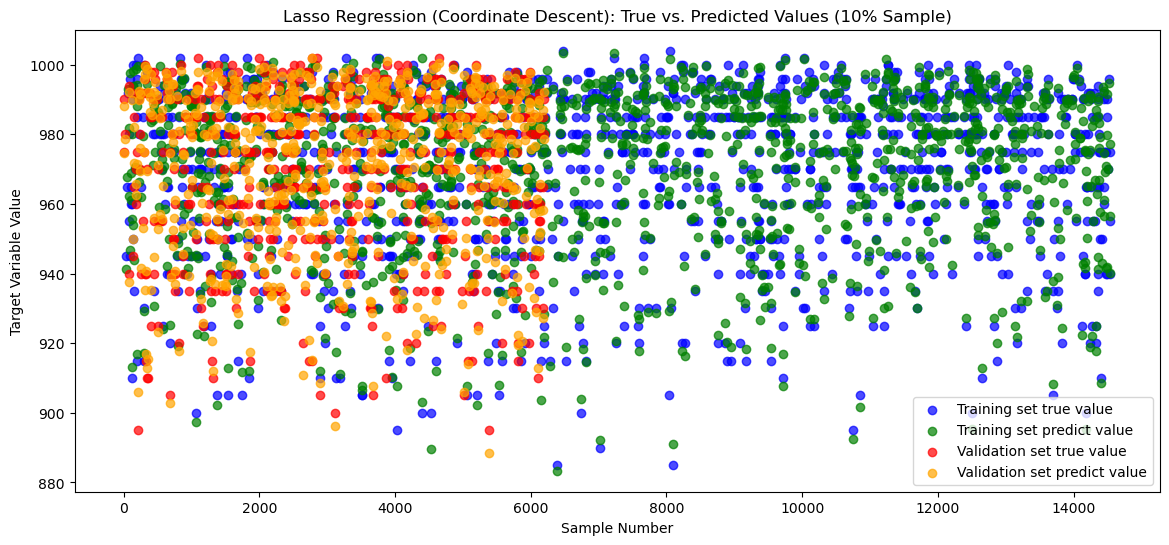

In [180]:

# Initialize the model using coordinate descent
ls1_model = ls.LassoRegression()

# 复制数据而不是直接引用
ls1_x_train = x_train.copy()
ls1_y_train = y_train.copy()
ls1_x_val = x_val.copy()
ls1_y_val = y_val.copy()

# Train the model
ls1_model.train(ls1_x_train, ls1_y_train, method='coordinate_descent', n_iters=1000, tol=1e-6, lambdas=0.2)

print("Lasso Regression (Coordinate Descent):")
# Predict on validation set
y_pred_ls1 = ls1_model.predict(ls1_x_val)
print("Training set MAPE:{:.3f}".format(mape(ls1_model.predict(ls1_x_train), y_train)))
print("Validation set MAPE:{:.3f}".format(mape(y_pred_ls1, y_val)))
print("Mean Absolute Error:", mean_absolute_error(y_val, y_pred_ls1))
print("R2 Score:", r2_score(y_val, y_pred_ls1))

# 保存指标数据
model_metrics['model_name'].append('Lasso Regression (Coordinate Descent)')
model_metrics['MAPE'].append(mape(y_pred_ls1, y_val))
model_metrics['MAE'].append(mean_absolute_error(y_val, y_pred_ls1))
model_metrics['R2_Score'].append(r2_score(y_val, y_pred_ls1))

# 绘图
plt.figure(figsize=(14, 6))

# 训练集预测值
y_train_pred_ls1 = ls1_model.predict(ls1_x_train)

# 随机选择 10% 的训练集样本用于绘图
train_sample_size = int(len(y_train) * 0.1)
train_indices = np.random.choice(len(y_train), size=train_sample_size, replace=False)

plt.scatter(train_indices, y_train[train_indices], color='blue', label='Training set true value', alpha=0.7)
plt.scatter(train_indices, y_train_pred_ls1[train_indices], color='green', label='Training set predict value', alpha=0.7)

# 验证集预测值
y_val_pred_ls1 = ls1_model.predict(ls1_x_val)

# 随机选择 10% 的验证集样本用于绘图
val_sample_size = int(len(y_val) * 0.1)
val_indices = np.random.choice(len(y_val), size=val_sample_size, replace=False)

plt.scatter(val_indices, y_val[val_indices], color='red', label='Validation set true value', alpha=0.7)
plt.scatter(val_indices, y_pred_ls1[val_indices], color='orange', label='Validation set predict value', alpha=0.7)

plt.title('Lasso Regression (Coordinate Descent): True vs. Predicted Values (10% Sample)')
plt.xlabel('Sample Number')
plt.ylabel('Target Variable Value')
plt.legend()
plt.show()
plt.close()


G:\operating_platform\Machine Learning\lab1\code\models\LassoRegression.py:252: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sx = np.linalg.lstsq(sa, sb)
G:\operating_platform\Machine Learning\lab1\code\models\LassoRegression.py:262: RuntimeWarning: divide by zero encountered in divide
  gamma_hat = -w / d_hat
G:\operating_platform\Machine Learning\lab1\code\models\LassoRegression.py:262: RuntimeWarning: invalid value encountered in divide
  gamma_hat = -w / d_hat


第1次迭代，损失平方和为14571504.548413575，损失前后差为13695688831.451586
第2次迭代，损失平方和为458280.79717314197，损失前后差为14113223.751240432
第3次迭代，损失平方和为411340.96293800604，损失前后差为46939.83423513593
第4次迭代，损失平方和为383319.40310978063，损失前后差为28021.559828225407
第5次迭代，损失平方和为379822.48993347737，损失前后差为3496.9131763032638
第6次迭代，损失平方和为323411.89161714894，损失前后差为56410.598316328425
第7次迭代，损失平方和为312265.6276877504，损失前后差为11146.263929398556
第8次迭代，损失平方和为301718.37151892955，损失前后差为10547.256168820837
Lasso Regression (Least Angle Regression):
Training set MAPE:0.025
Validation set MAPE:0.025
Mean Absolute Error: 3.229065606212385
R2 Score: 0.957056553239116


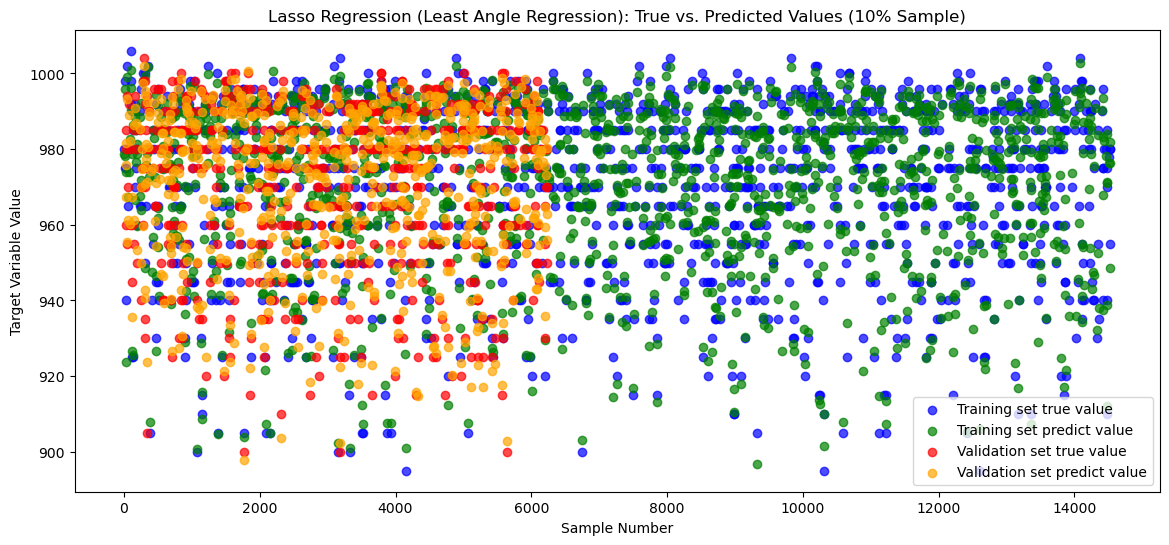

In [181]:
# Initialize the model using least angle regression
ls2_model = ls.LassoRegression()

# 复制数据而不是直接引用
ls2_x_train = x_train.copy()
ls2_y_train = y_train.copy()
ls2_x_val = x_val.copy()
ls2_y_val = y_val.copy()

# Train the model
ls2_model.train(ls2_x_train, ls2_y_train, method='least_angle_regression', n_iters=1000, tol=1e-6, lambdas=0.2)

print("Lasso Regression (Least Angle Regression):")
# Predict on validation set
y_pred_ls2 = ls2_model.predict(ls2_x_val)
print("Training set MAPE:{:.3f}".format(mape(ls2_model.predict(ls2_x_train), y_train)))
print("Validation set MAPE:{:.3f}".format(mape(y_pred_ls2, y_val)))
print("Mean Absolute Error:", mean_absolute_error(y_val, y_pred_ls2))
print("R2 Score:", r2_score(y_val, y_pred_ls2))

# 保存指标数据
model_metrics['model_name'].append('Lasso Regression (Least Angle Regression)')
model_metrics['MAPE'].append(mape(y_pred_ls2, y_val))
model_metrics['MAE'].append(mean_absolute_error(y_val, y_pred_ls2))
model_metrics['R2_Score'].append(r2_score(y_val, y_pred_ls2))

# 绘图
plt.figure(figsize=(14, 6))

# 训练集预测值
y_train_pred_ls2 = ls2_model.predict(ls2_x_train)

# 随机选择 10% 的训练集样本用于绘图
train_sample_size = int(len(y_train) * 0.1)
train_indices = np.random.choice(len(y_train), size=train_sample_size, replace=False)

plt.scatter(train_indices, y_train[train_indices], color='blue', label='Training set true value', alpha=0.7)
plt.scatter(train_indices, y_train_pred_ls2[train_indices], color='green', label='Training set predict value', alpha=0.7)

# 验证集预测值
y_val_pred_ls2 = ls2_model.predict(ls2_x_val)

# 随机选择 10% 的验证集样本用于绘图
val_sample_size = int(len(y_val) * 0.1)
val_indices = np.random.choice(len(y_val), size=val_sample_size, replace=False)

plt.scatter(val_indices, y_val[val_indices], color='red', label='Validation set true value', alpha=0.7)
plt.scatter(val_indices, y_pred_ls2[val_indices], color='orange', label='Validation set predict value', alpha=0.7)

plt.title('Lasso Regression (Least Angle Regression): True vs. Predicted Values (10% Sample)')
plt.xlabel('Sample Number')
plt.ylabel('Target Variable Value')
plt.legend()
plt.show()
plt.close()


RandomForest:
Training set MAPE:0.001
Validation set MAPE:0.003
Mean Absolute Error: 3.053786760774248
R2 Score: 0.9615005956103879


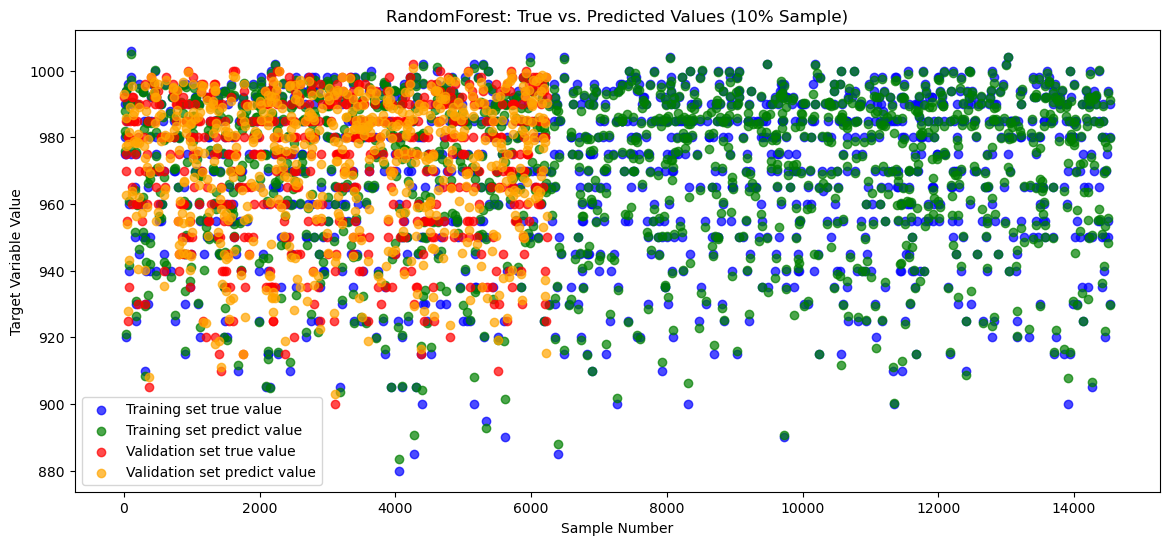

In [182]:
# Initialize the model
rf_model = RF.RandomForest(n_estimators=100, random_state=42)

# 复制数据而不是直接引用
rf_x_train = x_train.copy()
rf_y_train = y_train.copy()
rf_x_val = x_val.copy()
rf_y_val = y_val.copy()

# Train the model
rf_model.train(rf_x_train, rf_y_train)

print("RandomForest:")
# Predict on validation set
y_pred_rf = rf_model.predict(rf_x_val)
print("Training set MAPE:{:.3f}".format(mape(rf_model.predict(rf_x_train), y_train)))
print("Validation set MAPE:{:.3f}".format(mape(y_pred_rf, y_val)))
print("Mean Absolute Error:", mean_absolute_error(y_val, y_pred_rf))
print("R2 Score:", r2_score(y_val, y_pred_rf))

# 保存指标数据
model_metrics['model_name'].append('Random Forest')
model_metrics['MAPE'].append(mape(y_pred_rf, y_val))
model_metrics['MAE'].append(mean_absolute_error(y_val, y_pred_rf))
model_metrics['R2_Score'].append(r2_score(y_val, y_pred_rf))

# 设置随机种子（可选）
np.random.seed(42)

# 绘图
plt.figure(figsize=(14, 6))

# 训练集预测值
y_train_pred_rf = rf_model.predict(rf_x_train)

# 随机选择 10% 的训练集样本用于绘图
train_sample_size = int(len(y_train) * 0.1)
train_indices = np.random.choice(len(y_train), size=train_sample_size, replace=False)

plt.scatter(train_indices, y_train[train_indices], color='blue', label='Training set true value', alpha=0.7)
plt.scatter(train_indices, y_train_pred_rf[train_indices], color='green', label='Training set predict value', alpha=0.7)

# 验证集预测值
y_val_pred_rf = rf_model.predict(rf_x_val)

# 随机选择 10% 的验证集样本用于绘图
val_sample_size = int(len(y_val) * 0.1)
val_indices = np.random.choice(len(y_val), size=val_sample_size, replace=False)

plt.scatter(val_indices, y_val[val_indices], color='red', label='Validation set true value', alpha=0.7)
plt.scatter(val_indices, y_val_pred_rf[val_indices], color='orange', label='Validation set predict value', alpha=0.7)

plt.title('RandomForest: True vs. Predicted Values (10% Sample)')
plt.xlabel('Sample Number')
plt.ylabel('Target Variable Value')
plt.legend()
plt.show()
plt.close()

Epoch 1/200, Loss: 0.311313
Epoch 2/200, Loss: 0.131530
Epoch 3/200, Loss: 0.105076
Epoch 4/200, Loss: 0.095438
Epoch 5/200, Loss: 0.083447
Epoch 6/200, Loss: 0.078711
Epoch 7/200, Loss: 0.074505
Epoch 8/200, Loss: 0.071538
Epoch 9/200, Loss: 0.069712
Epoch 10/200, Loss: 0.066312
Epoch 11/200, Loss: 0.064024
Epoch 12/200, Loss: 0.063088
Epoch 13/200, Loss: 0.059822
Epoch 14/200, Loss: 0.059614
Epoch 15/200, Loss: 0.056934
Epoch 16/200, Loss: 0.057192
Epoch 17/200, Loss: 0.057381
Epoch 18/200, Loss: 0.055352
Epoch 19/200, Loss: 0.055055
Epoch 20/200, Loss: 0.055371
Epoch 21/200, Loss: 0.053026
Epoch 22/200, Loss: 0.051956
Epoch 23/200, Loss: 0.053644
Epoch 24/200, Loss: 0.054233
Epoch 25/200, Loss: 0.051825
Epoch 26/200, Loss: 0.053303
Epoch 27/200, Loss: 0.052321
Epoch 28/200, Loss: 0.051450
Epoch 29/200, Loss: 0.050513
Epoch 30/200, Loss: 0.051881
Epoch 31/200, Loss: 0.051763
Epoch 32/200, Loss: 0.052610
Epoch 33/200, Loss: 0.051288
Epoch 34/200, Loss: 0.049309
Epoch 35/200, Loss: 0.0

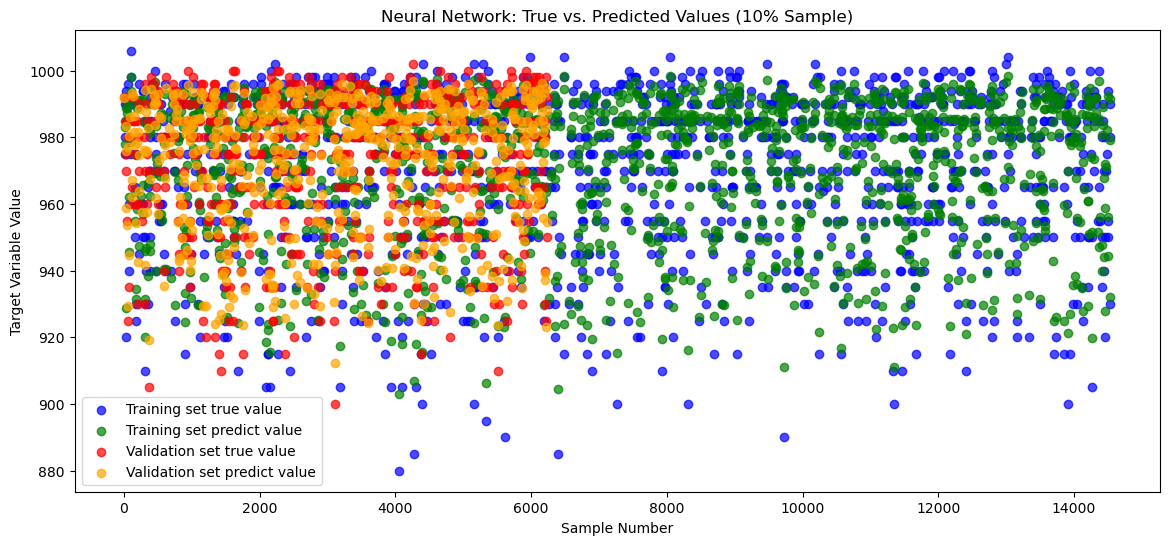

In [183]:
# Initialize the model
nn_model = nn.NeuralNetwork()

# 复制数据而不是直接引用
nn_x_train = x_train.copy()
nn_y_train = y_train.copy()
nn_x_val = x_val.copy()
nn_y_val = y_val.copy()

# Train the model
nn_model.train(nn_x_train, nn_y_train, learning_rate=0.001, n_iters=200, batch_size=512)

print("Neural Network:")
# Predict on validation set
y_pred_nn = nn_model.predict(nn_x_val)
print("Training set MAPE:{:.3f}".format(mape(nn_model.predict(nn_x_train), y_train)))
print("Validation set MAPE:{:.3f}".format(mape(y_pred_nn, y_val)))
print("Mean Absolute Error:", mean_absolute_error(y_val, y_pred_nn))
print("R2 Score:", r2_score(y_val, y_pred_nn))

# 保存指标数据
model_metrics['model_name'].append('Neural Network')
model_metrics['MAPE'].append(mape(y_pred_nn, y_val))
model_metrics['MAE'].append(mean_absolute_error(y_val, y_pred_nn))
model_metrics['R2_Score'].append(r2_score(y_val, y_pred_nn))

# 设置随机种子（可选）
np.random.seed(42)

# 绘图
plt.figure(figsize=(14, 6))

# 训练集预测值
y_train_pred_nn = nn_model.predict(nn_x_train)

# 随机选择 10% 的训练集样本用于绘图
train_sample_size = int(len(y_train) * 0.1)
train_indices = np.random.choice(len(y_train), size=train_sample_size, replace=False)

plt.scatter(train_indices, y_train[train_indices], color='blue', label='Training set true value', alpha=0.7)
plt.scatter(train_indices, y_train_pred_nn[train_indices], color='green', label='Training set predict value', alpha=0.7)

# 验证集预测值
y_val_pred_nn = nn_model.predict(nn_x_val)

# 随机选择 10% 的验证集样本用于绘图
val_sample_size = int(len(y_val) * 0.1)
val_indices = np.random.choice(len(y_val), size=val_sample_size, replace=False)

plt.scatter(val_indices, y_val[val_indices], color='red', label='Validation set true value', alpha=0.7)
plt.scatter(val_indices, y_val_pred_nn[val_indices], color='orange', label='Validation set predict value', alpha=0.7)

plt.title('Neural Network: True vs. Predicted Values (10% Sample)')
plt.xlabel('Sample Number')
plt.ylabel('Target Variable Value')
plt.legend()
plt.show()
plt.close()

GBDT:
Training set MAPE:0.003
Validation set MAPE:0.003
Mean Absolute Error: 2.977736326359972
R2 Score: 0.9643295165329563


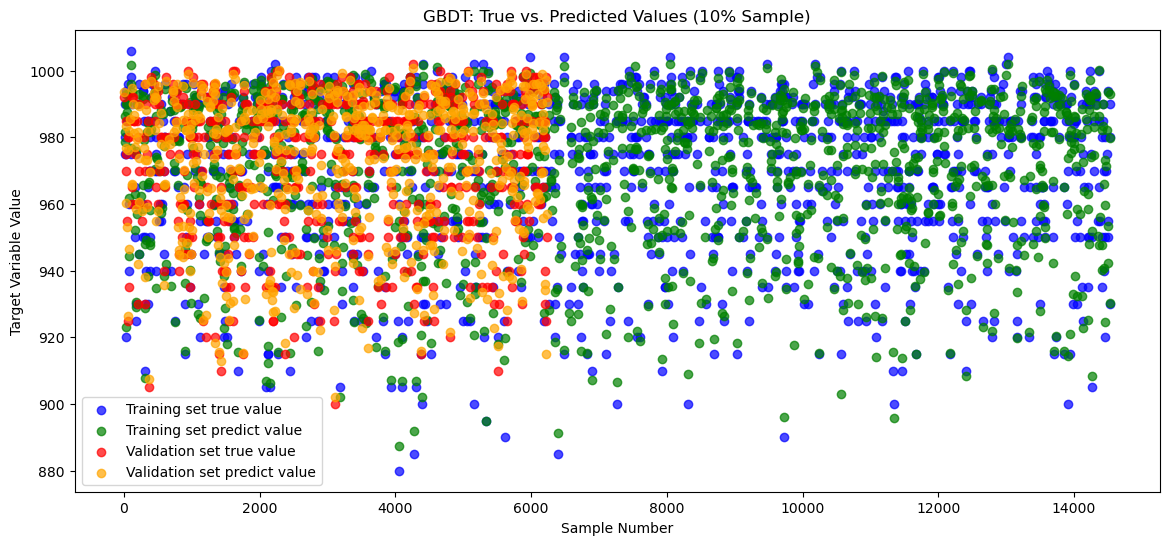

In [184]:
# Initialize the model
gbdt_model = gbdt.GBDT()

# 复制数据而不是直接引用
gbdt_x_train = x_train.copy()
gbdt_y_train = y_train.copy()
gbdt_x_val = x_val.copy()
gbdt_y_val = y_val.copy()

# Train the model
gbdt_model.train(gbdt_x_train, gbdt_y_train)

print("GBDT:")
# Predict on validation set
y_pred_gbdt = gbdt_model.predict(gbdt_x_val)
print("Training set MAPE:{:.3f}".format(mape(gbdt_model.predict(gbdt_x_train), y_train)))
print("Validation set MAPE:{:.3f}".format(mape(y_pred_gbdt, y_val)))
print("Mean Absolute Error:", mean_absolute_error(y_val, y_pred_gbdt))
print("R2 Score:", r2_score(y_val, y_pred_gbdt))

# 保存指标数据
model_metrics['model_name'].append('GBDT')
model_metrics['MAPE'].append(mape(y_pred_gbdt, y_val))
model_metrics['MAE'].append(mean_absolute_error(y_val, y_pred_gbdt))
model_metrics['R2_Score'].append(r2_score(y_val, y_pred_gbdt))

# 设置随机种子（可选）
np.random.seed(42)

# 绘图
plt.figure(figsize=(14, 6))

# 训练集预测值
y_train_pred_gbdt = gbdt_model.predict(gbdt_x_train)

# 随机选择 10% 的训练集样本用于绘图
train_sample_size = int(len(y_train) * 0.1)
train_indices = np.random.choice(len(y_train), size=train_sample_size, replace=False)

plt.scatter(train_indices, y_train[train_indices], color='blue', label='Training set true value', alpha=0.7)
plt.scatter(train_indices, y_train_pred_gbdt[train_indices], color='green', label='Training set predict value', alpha=0.7)

# 验证集预测值
y_val_pred_gbdt = gbdt_model.predict(gbdt_x_val)

# 随机选择 10% 的验证集样本用于绘图
val_sample_size = int(len(y_val) * 0.1)
val_indices = np.random.choice(len(y_val), size=val_sample_size, replace=False)

plt.scatter(val_indices, y_val[val_indices], color='red', label='Validation set true value', alpha=0.7)
plt.scatter(val_indices, y_val_pred_gbdt[val_indices], color='orange', label='Validation set predict value', alpha=0.7)

plt.title('GBDT: True vs. Predicted Values (10% Sample)')
plt.xlabel('Sample Number')
plt.ylabel('Target Variable Value')
plt.legend()
plt.show()
plt.close()


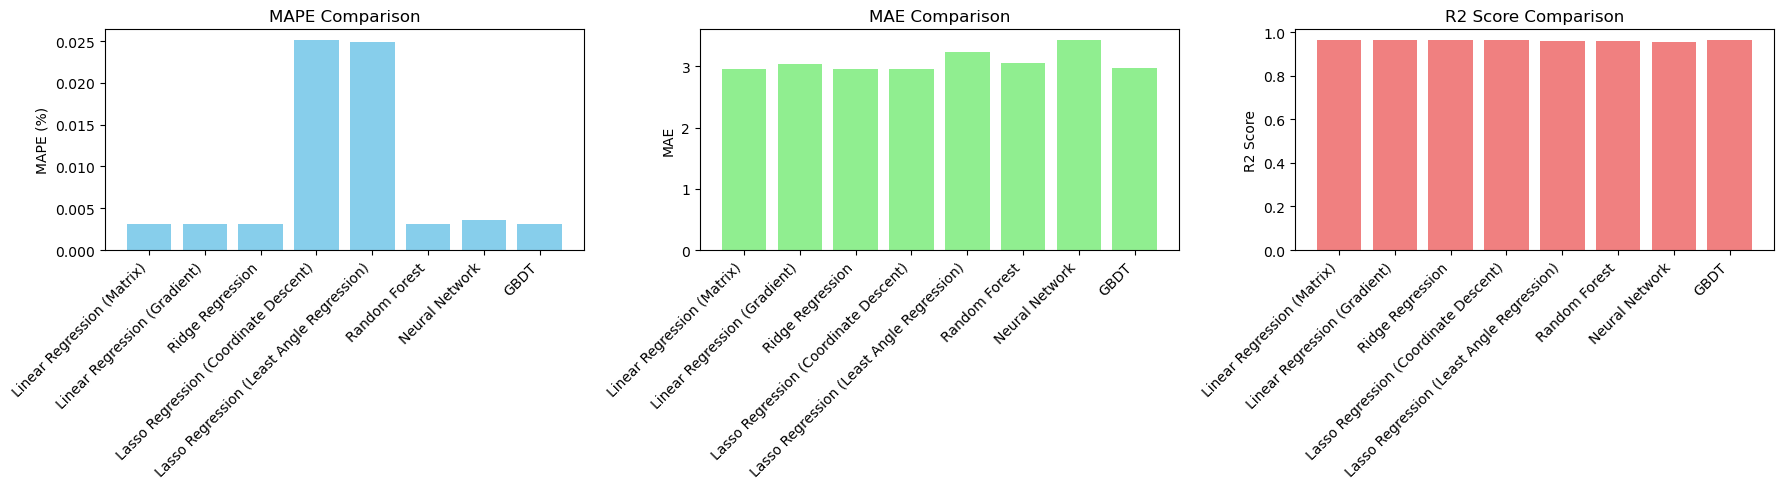

In [185]:
# 从model_metrics字典中提取数据
models = model_metrics['model_name']
mape_values = model_metrics['MAPE']
mae_values = model_metrics['MAE']
r2_scores = model_metrics['R2_Score']

# 绘制模型性能对比的条形图
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.bar(models, mape_values, color='skyblue')
plt.title('MAPE Comparison')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 3, 2)
plt.bar(models, mae_values, color='lightgreen')
plt.title('MAE Comparison')
plt.ylabel('MAE')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 3, 3)
plt.bar(models, r2_scores, color='lightcoral')
plt.title('R2 Score Comparison')
plt.ylabel('R2 Score')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


Ensemble Model (Weighted Average):
Validation set MAPE: 0.003
Mean Absolute Error: 2.8917738265566046
R2 Score: 0.9659887077572226


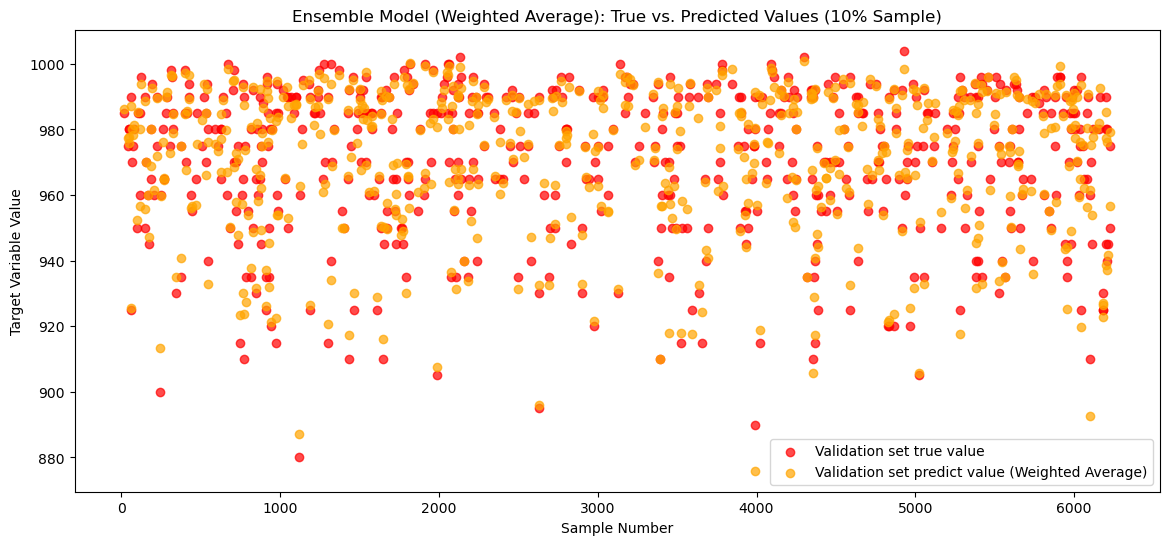

In [186]:
# 集合模型：集合了最好的三种效果的模型：lr、rr、gbdt

# 复制数据而不是直接引用
ensemble_x_train = x_train.copy()
ensemble_y_train = y_train.copy()
ensemble_x_val = x_val.copy()
ensemble_y_val = y_val.copy()

# Predict on validation set for each model
y_pred_lr1 = lr1_model.predict(ensemble_x_val)
y_pred_rr = rr_model.predict(ensemble_x_val)
y_pred_gbdt = gbdt_model.predict(ensemble_x_val)

# Assign weights to each model's prediction (you can adjust these weights based on validation performance)
lr1_weight = 0.4
rr_weight = 0.4
gbdt_weight = 0.2

# Combine the predictions using weighted average
y_pred_ensemble_weighted = (
    lr1_weight * y_pred_lr1 +
    rr_weight * y_pred_rr +
    gbdt_weight * y_pred_gbdt
)

# Evaluate the ensemble model (weighted average)
print("Ensemble Model (Weighted Average):")
print("Validation set MAPE: {:.3f}".format(mape(y_pred_ensemble_weighted, y_val)))
print("Mean Absolute Error:", mean_absolute_error(y_val, y_pred_ensemble_weighted))
print("R2 Score:", r2_score(y_val, y_pred_ensemble_weighted))

# 保存指标数据
model_metrics['model_name'].append('Ensemble Model (Weighted Average)')
model_metrics['MAPE'].append(mape(y_pred_ensemble_weighted, y_val))
model_metrics['MAE'].append(mean_absolute_error(y_val, y_pred_ensemble_weighted))
model_metrics['R2_Score'].append(r2_score(y_val, y_pred_ensemble_weighted))

# 绘图 - 加权平均集成模型
plt.figure(figsize=(14, 6))

# 随机选择 10% 的验证集样本用于绘图
val_sample_size = int(len(y_val) * 0.1)
val_indices = np.random.choice(len(y_val), size=val_sample_size, replace=False)

plt.scatter(val_indices, y_val[val_indices], color='red', label='Validation set true value', alpha=0.7)
plt.scatter(val_indices, y_pred_ensemble_weighted[val_indices], color='orange', label='Validation set predict value (Weighted Average)', alpha=0.7)

plt.title('Ensemble Model (Weighted Average): True vs. Predicted Values (10% Sample)')
plt.xlabel('Sample Number')
plt.ylabel('Target Variable Value')
plt.legend()
plt.show()
plt.close()

Ensemble Model (Meta-Learner):
Validation set MAPE: 0.003
Mean Absolute Error: 2.864731334119127
R2 Score: 0.9665305399851299


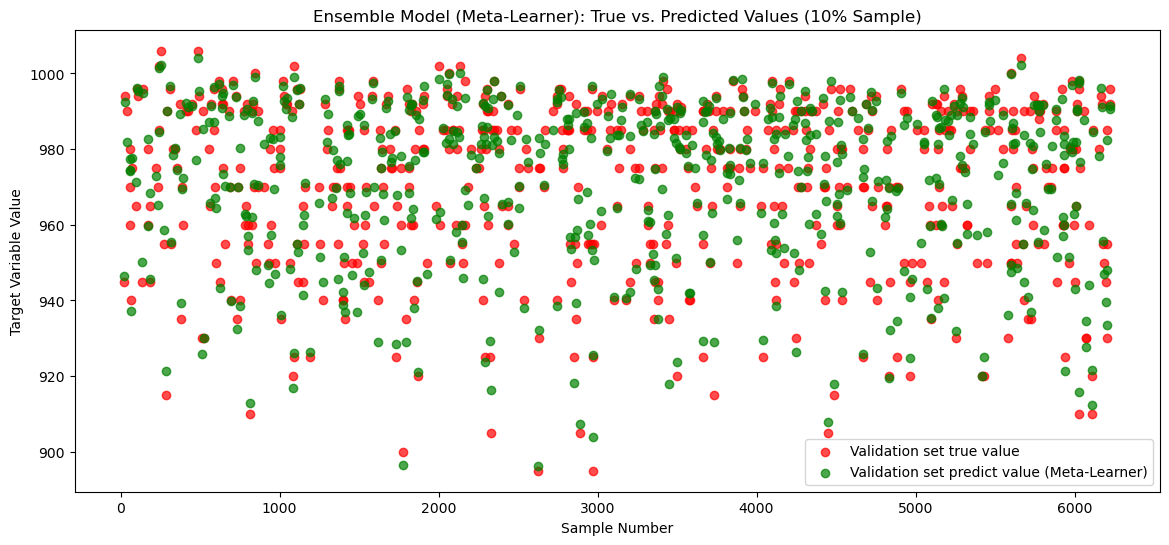

In [187]:
# Train the ensemble model (using a meta-learner)
from sklearn.linear_model import LinearRegression

# Stack predictions as features for the meta-learner
X_meta_train = np.column_stack((
    lr1_model.predict(ensemble_x_train),
    rr_model.predict(ensemble_x_train),
    gbdt_model.predict(ensemble_x_train)
))

# Use true labels from training set
y_meta_train = ensemble_y_train

# Initialize and train the meta-learner
meta_learner = LinearRegression()
meta_learner.fit(X_meta_train, y_meta_train)

# Predict on validation set using the meta-learner
X_meta_val = np.column_stack((
    y_pred_lr1,
    y_pred_rr,
    y_pred_gbdt
))

y_pred_ensemble_meta = meta_learner.predict(X_meta_val)

# Evaluate the ensemble model (meta-learner)
print("Ensemble Model (Meta-Learner):")
print("Validation set MAPE: {:.3f}".format(mape(y_pred_ensemble_meta, y_val)))
print("Mean Absolute Error:", mean_absolute_error(y_val, y_pred_ensemble_meta))
print("R2 Score:", r2_score(y_val, y_pred_ensemble_meta))

# 保存指标数据
model_metrics['model_name'].append('Ensemble Model (Meta-Learner)')
model_metrics['MAPE'].append(mape(y_pred_ensemble_meta, y_val))
model_metrics['MAE'].append(mean_absolute_error(y_val, y_pred_ensemble_meta))
model_metrics['R2_Score'].append(r2_score(y_val, y_pred_ensemble_meta))

# 绘图 - 元学习集成模型
plt.figure(figsize=(14, 6))

# 随机选择 10% 的验证集样本用于绘图
val_sample_size = int(len(y_val) * 0.1)
val_indices = np.random.choice(len(y_val), size=val_sample_size, replace=False)

plt.scatter(val_indices, y_val[val_indices], color='red', label='Validation set true value', alpha=0.7)
plt.scatter(val_indices, y_pred_ensemble_meta[val_indices], color='green', label='Validation set predict value (Meta-Learner)', alpha=0.7)

plt.title('Ensemble Model (Meta-Learner): True vs. Predicted Values (10% Sample)')
plt.xlabel('Sample Number')
plt.ylabel('Target Variable Value')
plt.legend()
plt.show()
plt.close()

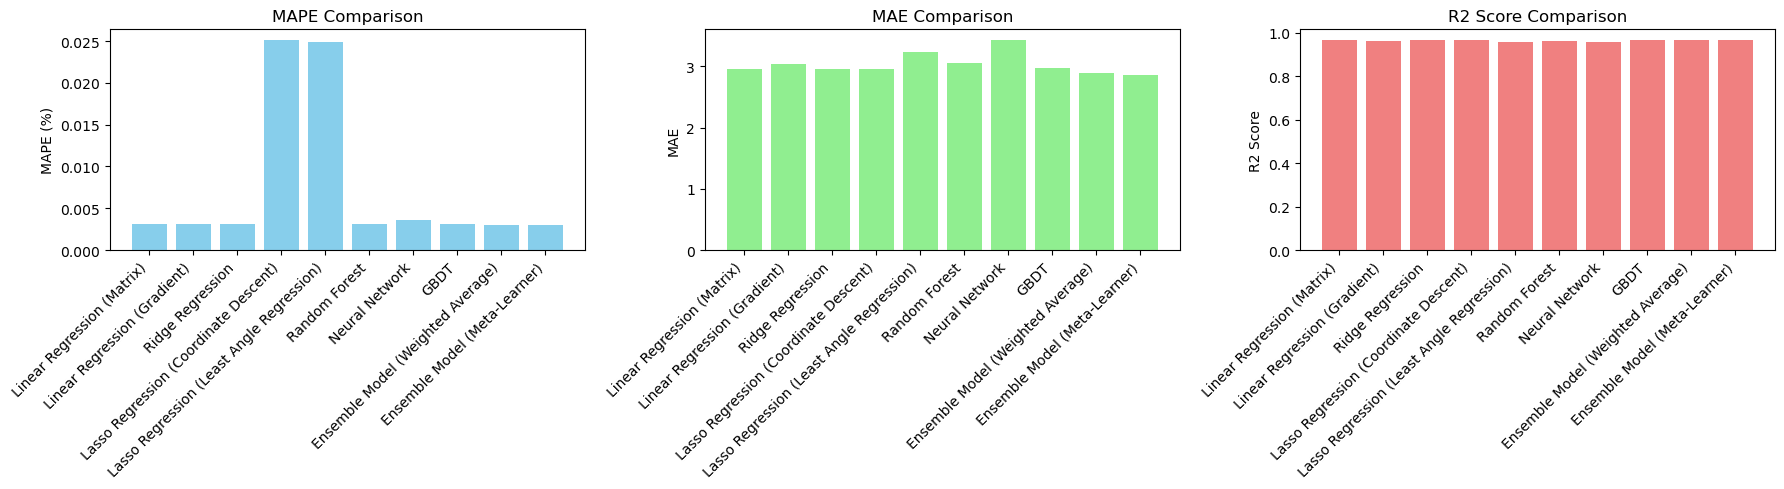

In [188]:
# 从model_metrics字典中提取数据
models = model_metrics['model_name']
mape_values = model_metrics['MAPE']
mae_values = model_metrics['MAE']
r2_scores = model_metrics['R2_Score']

# 绘制模型性能对比的条形图
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.bar(models, mape_values, color='skyblue')
plt.title('MAPE Comparison')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 3, 2)
plt.bar(models, mae_values, color='lightgreen')
plt.title('MAE Comparison')
plt.ylabel('MAE')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 3, 3)
plt.bar(models, r2_scores, color='lightcoral')
plt.title('R2 Score Comparison')
plt.ylabel('R2 Score')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()